In [4]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import pid, linear_mpc, ref, zero
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
from scipy import signal

ACC_G = 9.81

sns.set_theme()


In [5]:
def plot_rollout(sim):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(sim.target_lataccel_history, label="Target Lateral Acceleration", alpha=0.5)
  ax.plot(sim.current_lataccel_history, label="Actual Lateral Acceleration", alpha=0.5)
  ax.plot(sim.action_history, label="Action", alpha=0.5)
  # ax.plot([x[2] for x in sim.state_history], label="aEgo", alpha=0.5)

  ax.legend()
  ax.set_xlabel("Step")
  ax.set_ylabel("Lateral Acceleration")
  ax.set_title("Rollout")
  plt.show()

In [6]:
model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
controller_pid = pid.Controller()
controller_ff = linear_mpc.Controller()

In [7]:
sim = TinyPhysicsSimulator(model, "./data/00000.csv", controller=controller_ff, debug=False)
sim.rollout()

{'lataccel_cost': 1.0241998403733419,
 'jerk_cost': 36.425460500262936,
 'total_cost': 87.63545251893004}

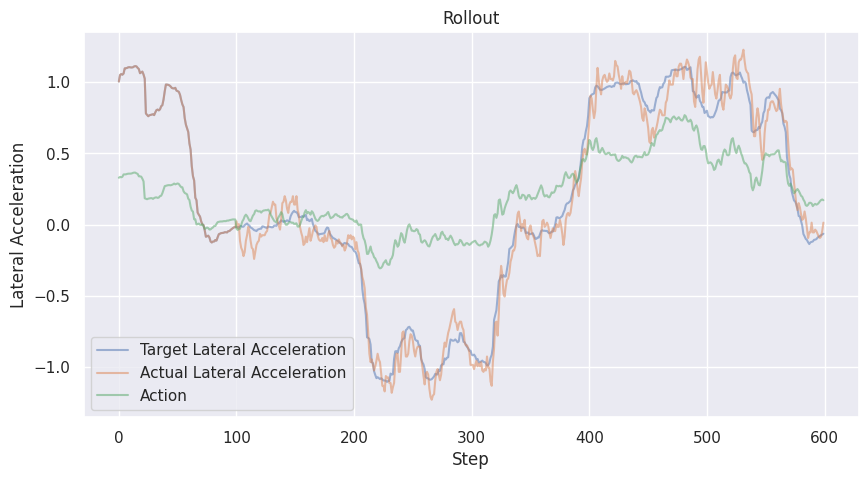

In [8]:
plot_rollout(sim)

In [9]:
corr = signal.correlate(steer_lataccel_history - steer_lataccel_history.mean(), action_history - action_history.mean())
lags = signal.correlation_lags(len(steer_lataccel_history), len(steer_lataccel_history))
print(lags[np.argmax(corr)])
plt.plot(lags, corr)
plt.show()

NameError: name 'steer_lataccel_history' is not defined

lag: 7
lag: 7
alpha: 1.3876417762003095
beta: -0.16303740404018455
R^2: 0.8362933784489845


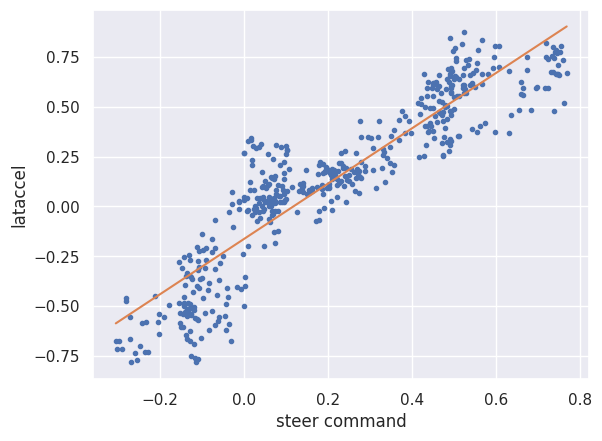

In [11]:
def linear_lsq(x, y, lag):
    length = len(x)
    alpha = np.sum((y[lag:] - y[lag:].mean()) * (x[:length-lag] - x[:length-lag].mean())) / (np.sum((x[:length-lag] - x[:length-lag].mean()) ** 2) + 1e-8)
    beta = y[lag:].mean() - alpha * x[:length-lag].mean()

    ssr = np.sum((alpha * x[:length-lag] + beta - y[lag:])**2)
    sst = np.sum((y[lag:] - y[lag:].mean())**2) + 1e-8
    r2 = 1 - ssr / sst

    return alpha, beta, r2

roll_lataccel_history = [x[0] for x in sim.state_history][100:]

steer_la = np.array(sim.current_lataccel_history)[100:] - np.array(roll_lataccel_history)
steerCommands = np.array(sim.action_history)[100:]
vEgo = np.array([x[1] for x in sim.state_history[100:]])
aEgo = np.array([x[2] for x in sim.state_history[100:]])

length = len(steerCommands)


corr = signal.correlate(steer_la - steer_la.mean(), steerCommands - steerCommands.mean())
lags = signal.correlation_lags(length, length)
lag = lags[np.argmax(corr)]
print(f'lag: {lag}')
lag = max(0, lag)

test_fit = np.array([linear_lsq(steerCommands, steer_la, x)[2] for x in range(lag, lag + 10)])
lag += np.argmax(test_fit)

print(f'lag: {lag}')

# lag=0
alpha = np.sum((steer_la[lag:] - steer_la[lag:].mean()) * (steerCommands[:length-lag] - steerCommands[:length-lag].mean())) / np.sum((steerCommands[:length-lag] - steerCommands[:length-lag].mean()) ** 2)
beta = steer_la[lag:].mean() - alpha * steerCommands[:length-lag].mean()
ssr = np.sum((alpha * steerCommands[:length-lag] + beta - steer_la[lag:])**2)
sst = np.sum((steer_la[lag:] - steer_la[lag:].mean())**2)
r2 = 1 - ssr / sst
print(f'alpha: {alpha}\nbeta: {beta}\nR^2: {r2}')

plt.plot(steerCommands[:length-lag], steer_la[lag:], '.')
x = np.linspace(steerCommands.min(), steerCommands.max(), 2)
plt.plot(x, alpha * x + beta)

plt.xlabel('steer command')
plt.ylabel('lataccel')
# plt.xlim(-2, 2)
# plt.ylim(-3, 3)
plt.show()



# fig, ax = plt.subplots(2, 1, figsize=(7, 10))
# ax[0].scatter(action_history[:-lag], steer_lataccel_history[lag:], marker='.', linewidths=0.5)
# ax[1].scatter(action_history[:100], steer_lataccel_history[lag:100+lag], marker='.', linewidths=0.5)



# plt.xlabel('steer command')
# plt.ylabel('actual lataccel')
# # plt.xlim(-2, 2)
# # plt.ylim(-3, 3)
# plt.show()

In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas

states = {
    # "vEgo": vEgo,
    "aEgo": aEgo,
    "steerCommand": steerCommands,
    "steerLataccel": steer_la
}

df = pandas.DataFrame.from_dict(states)
mod = smf.ols(formula='steerLataccel ~  aEgo + steerCommand', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          steerLataccel   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     873.4
Date:                Sat, 17 Aug 2024   Prob (F-statistic):          2.12e-163
Time:                        00:12:21   Log-Likelihood:                 110.22
No. Observations:                 500   AIC:                            -214.4
Df Residuals:                     497   BIC:                            -201.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1538      0.011    -13.946   